# Практическое задание

Используем набор примеров fashion-MNIST

1.  Опишите - какой результата получен в нейросети в зависимости от:
  -  числа нейронов в слое(для 2-хслойной сети), 
  - числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых парметров).
  - фиксируйте для тренировочного и тестового набора метрики accuracy.
2.  Проверьте работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей п.1.Фиксируйте для тренировочного и тестового набора метрики accuracy.

3. Сделайте вывод - что помогло вам улучшить качество классификации в нейросети на тестовом наборе? 

4. Для одного варианта сетей сформируйте матрицу ошибок по классам. Оцените качество модели по каждому классу отдельно (полнота , точность)

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical

Загрузка Fashion_MNIST

In [3]:
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images,
                               test_labels) = fashion_mnist.load_data()

In [4]:
class_names = ['Футболка / топ', "Шорты / штаны", "Свитер", "Платье",
              "Плащ", "Сандали", "Рубашка", "Кроссовок", "Сумка",
              "Ботинок"]

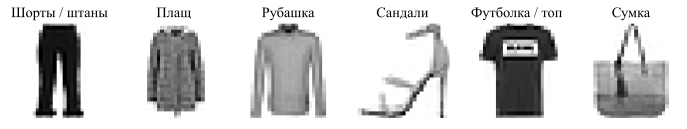

In [5]:
sample = [1211, 3445, 56744, 899, 1, 35]
N = len(sample)
plt.figure(figsize=(2 * N, 5))
for num, i in enumerate(sample, 1):
    plt.subplot(1, N, num)
    plt.imshow(train_images[i, :, :], cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.title(class_names[train_labels[i]])
    plt.grid(False)
plt.show()

In [6]:
test_images_show = test_images.copy()
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))
input_size = train_images.shape[1]
print(input_size)

784


In [7]:
# Normalize the images.
train_images = (train_images / 255) * 2 - 1
test_images = (test_images / 255) * 2 - 1

In [8]:
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

**Создание модели**

In [9]:
def nn_test(train_images,
            y_train,
            test_images,
            y_test,
            n1_neuron: int = 128,
            n2_neuron: int = 128,
            n_layers: int = 2,  # c учетом входного
            optimizer: str = 'adam',
            n_epochs: int = 15,
            batch_size: int = 128,
            validation_split: float = 0.2,
            verbose=True):

    # входной слой + поносвязный слой из 128 нейронов с активацией ReLU
    model = Sequential()
    model.add(Dense(n1_neuron, activation='relu', input_shape=(input_size,)))

    if n_layers > 2:  # добавление скрытых слоев
        for k in range(n_layers-2):
            model.add(Dense(n2_neuron, activation='tanh'))

    model.add(Dense(10, activation='softmax'))
    # выходной слой из 10 нейронов (сколько классов, столько нейронов) + активация softmax

    model.compile(
        optimizer=optimizer,  # оптимизатор
        loss=keras.losses.CategoricalCrossentropy(),  # функция потерь
        metrics=['accuracy'],  # метрика
    )
#     model.summary()

    history = model.fit( train_images,
                        y_train,
                        epochs=n_epochs,
                        batch_size=batch_size,
                        validation_split=validation_split,
                        verbose=verbose)

    model.evaluate(
        test_images,
        y_test
    )
    return history.history


# Проверка обучения с разным количеством нейронов скрытого слоя

In [10]:
test_dict = {}
x = np.linspace(1, 20, 20)
for n_neurons in [2, 4, 8, 32, 96, 192]:
    test_dict[n_neurons] = nn_test(train_images,
                                   y_train,
                                   test_images,
                                   y_test,
                                   n1_neuron=n_neurons,
                                   n2_neuron=None,
                                   n_layers=2,
                                   optimizer='adam',
                                   n_epochs=20,
                                   batch_size=128,
                                   validation_split=0.2,
                                   verbose=False)

313/313 [==============================] - 0s 657us/step - loss: 0.3857 - accuracy: 0.8823


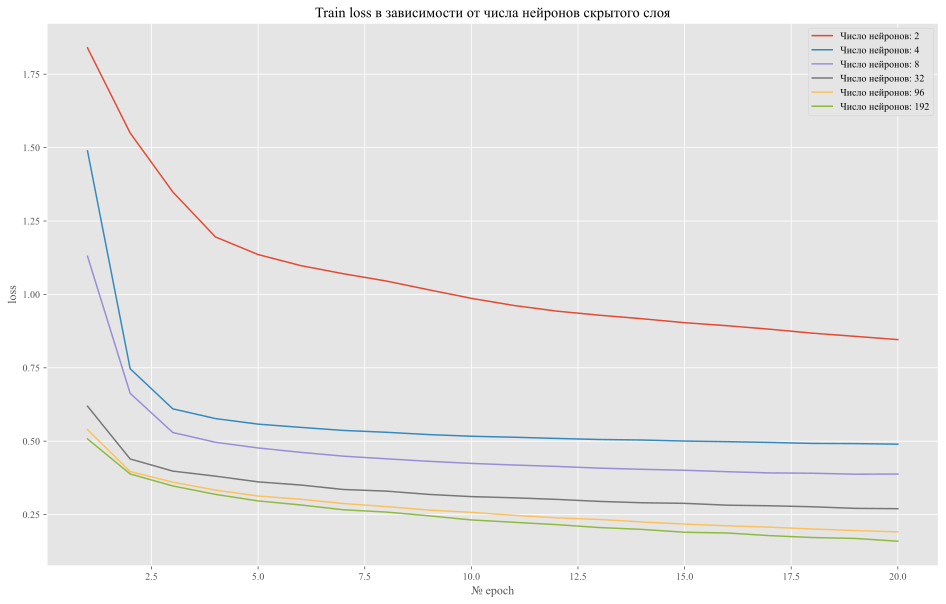

In [11]:
plt.figure(figsize=(16, 10))
for n_neur in test_dict:
        plt.plot(x, test_dict[n_neur]['loss'], label=f'Число нейронов: {n_neur}')
plt.legend(loc='best')
plt.xlabel('№ epoch')
plt.ylabel('loss')
plt.title('Train loss в зависимости от числа нейронов скрытого слоя')
plt.show()

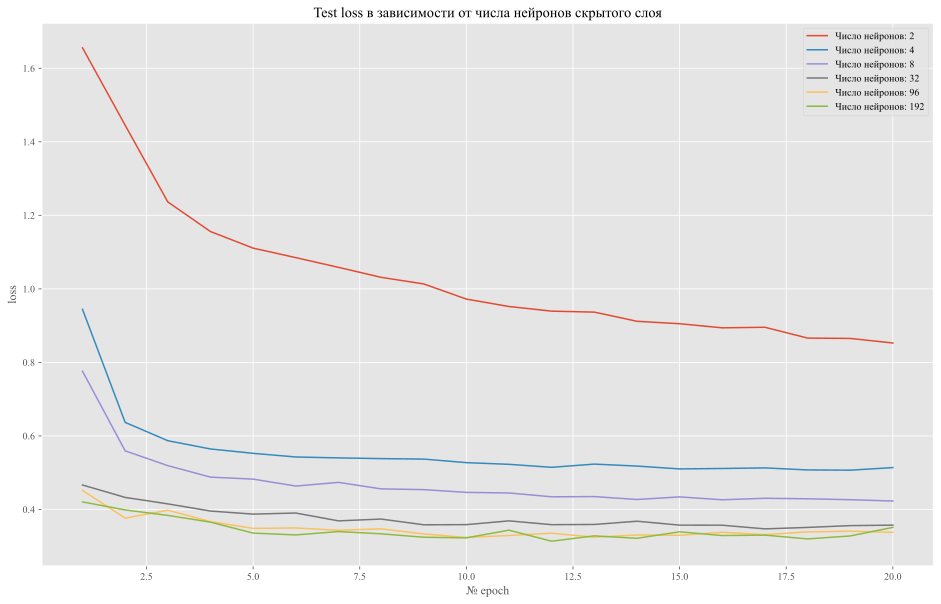

In [12]:
plt.figure(figsize=(16, 10))
for n_neur in test_dict:
        plt.plot(x, test_dict[n_neur]['val_loss'], label=f'Число нейронов: {n_neur}')
plt.legend(loc='best')
plt.xlabel('№ epoch')
plt.ylabel('loss')
plt.title('Test loss в зависимости от числа нейронов скрытого слоя')
plt.show()

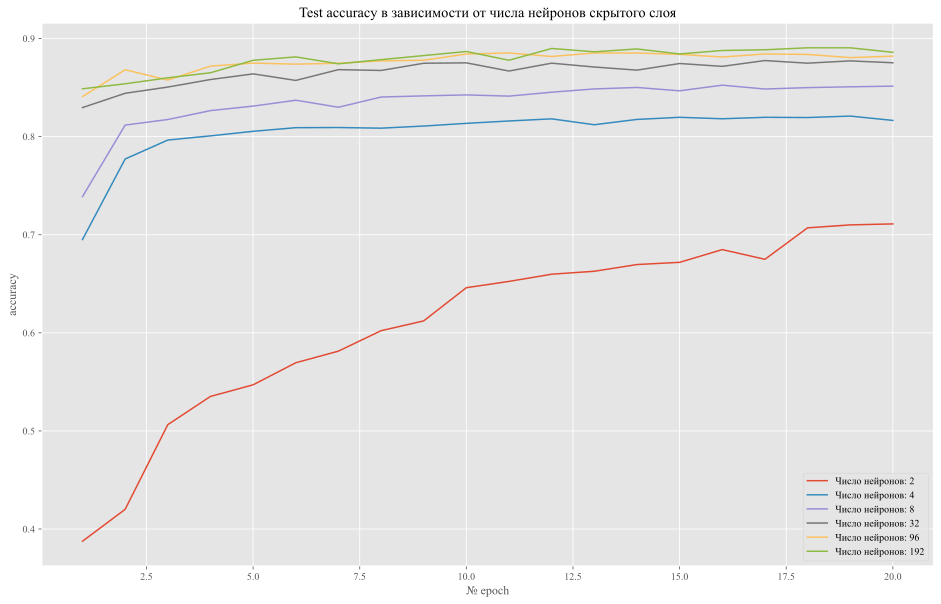

In [13]:
plt.figure(figsize=(16, 10))
for n_neur in test_dict:
        plt.plot(x, test_dict[n_neur]['val_accuracy'], label=f'Число нейронов: {n_neur}')
plt.legend(loc='best')
plt.xlabel('№ epoch')
plt.ylabel('accuracy')
plt.title('Test accuracy в зависимости от числа нейронов скрытого слоя')
plt.show()

# Провeрка обучения с разным количеством скрытых слоев

In [14]:
test_dict = {}
x = np.linspace(1, 20, 20)
for params in [(2, 128), # подобрано под Total params: 101k
               (3, 112),
               (5, 94),
               (10, 73)]:

    test_dict[params[0]] = nn_test(train_images,
                                   y_train,
                                   test_images,
                                   y_test,
                                   n1_neuron=params[1],
                                   n2_neuron=params[1],
                                   n_layers=params[0],
                                   optimizer='adam',
                                   n_epochs=20,
                                   batch_size=128,
                                   validation_split=0.2,
                                   verbose=False)

313/313 [==============================] - 0s 942us/step - loss: 0.3666 - accuracy: 0.8806


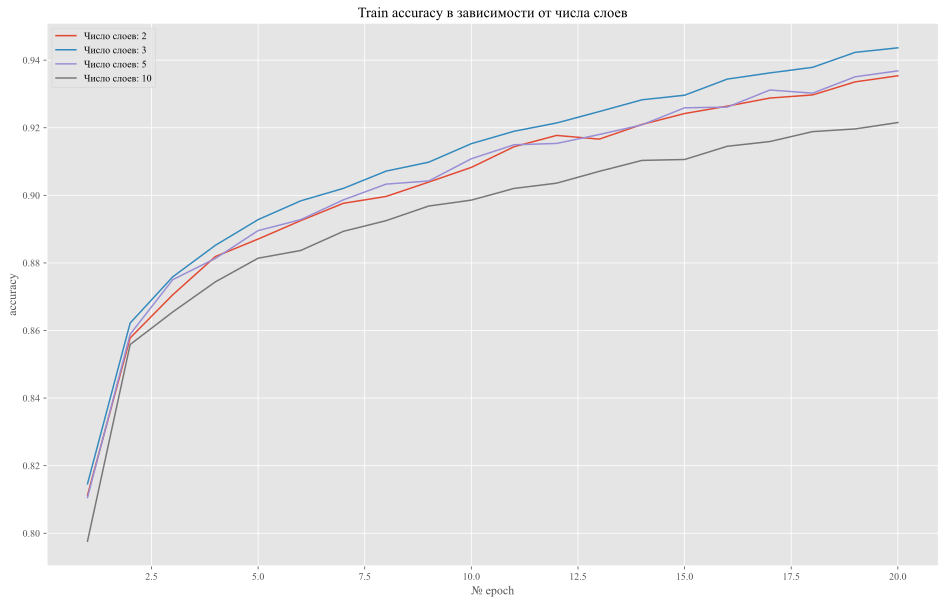

In [15]:
plt.figure(figsize=(16, 10))
for n_layers in test_dict:
        plt.plot(x, test_dict[n_layers]['accuracy'], label=f'Число слоев: {n_layers}')
plt.legend(loc='best')
plt.xlabel('№ epoch')
plt.ylabel('accuracy')
plt.title('Train accuracy в зависимости от числа слоев')
plt.show()

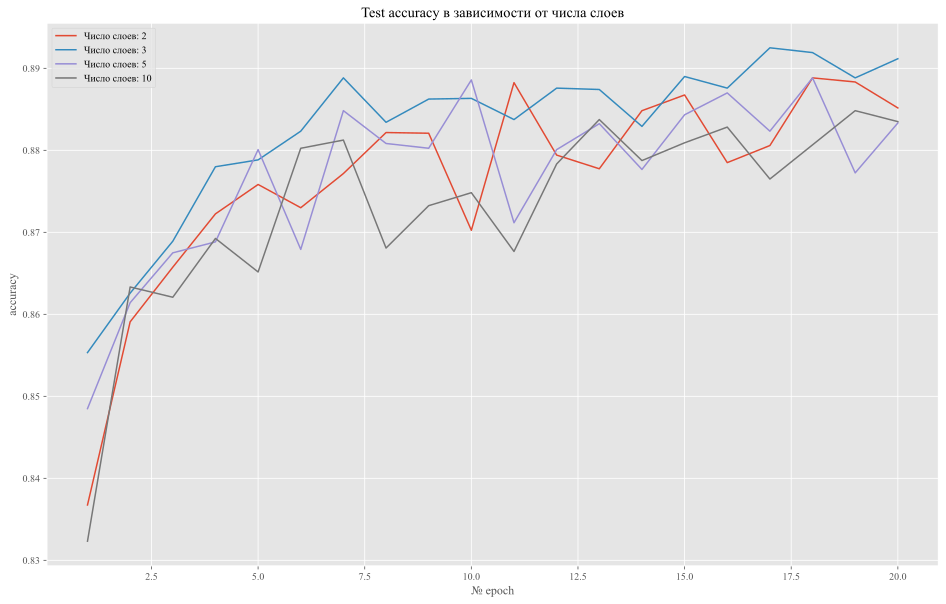

In [16]:
plt.figure(figsize=(16, 10))
for n_layers in test_dict:
        plt.plot(x, test_dict[n_layers]['val_accuracy'], label=f'Число слоев: {n_layers}')
plt.legend(loc='best')
plt.xlabel('№ epoch')
plt.ylabel('accuracy')
plt.title('Test accuracy в зависимости от числа слоев')
plt.show()

# Провeрка обучения с разными оптимизаторами

In [17]:
test_dict = {}
x = np.linspace(1, 20, 20)
for optim in [keras.optimizers.RMSprop(), keras.optimizers.SGD(), keras.optimizers.Adam(), keras.optimizers.Nadam()]:
    test_dict[optim.__class__.__name__] = nn_test(train_images,
                                                 y_train,
                                                 test_images,
                                                 y_test,
                                                 n1_neuron=128,
                                                 n2_neuron=None,
                                                 n_layers=2,
                                                 optimizer=optim,
                                                 n_epochs=20,
                                                 batch_size=128,
                                                 validation_split=0.2,
                                                 verbose=False)

313/313 [==============================] - 0s 677us/step - loss: 0.3738 - accuracy: 0.8791


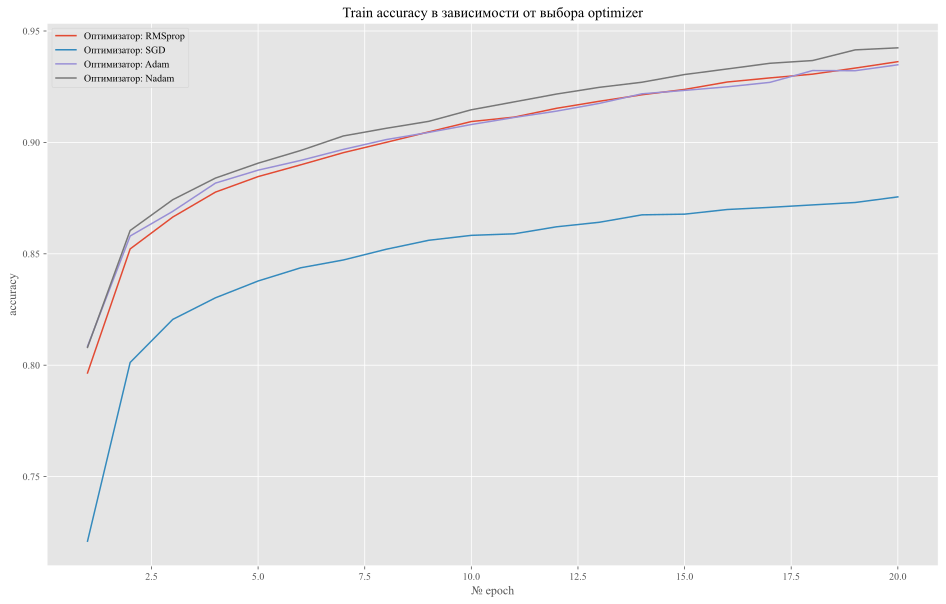

In [18]:
plt.figure(figsize=(16, 10))
for optim in test_dict:
        plt.plot(x, test_dict[optim]['accuracy'], label=f'Оптимизатор: {optim}')
plt.legend(loc='best')
plt.xlabel('№ epoch')
plt.ylabel('accuracy')
plt.title('Train accuracy в зависимости от выбора optimizer')
plt.show()

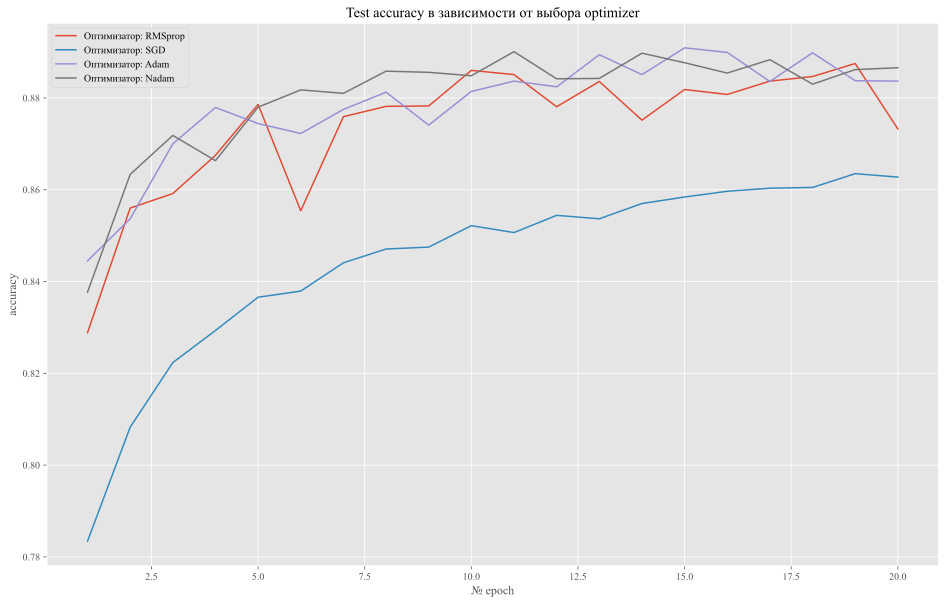

In [19]:
plt.figure(figsize=(16, 10))
for optim in test_dict:
        plt.plot(x, test_dict[optim]['val_accuracy'], label=f'Оптимизатор: {optim}')
plt.legend(loc='best')
plt.xlabel('№ epoch')
plt.ylabel('accuracy')
plt.title('Test accuracy в зависимости от выбора optimizer')
plt.show()

*******************

In [20]:
test_model = Sequential()
test_model.add(Dense(128, activation='relu', input_shape=(input_size,)))
test_model.add(Dense(10, activation='softmax'))

test_model.compile(
    optimizer='nadam',  # оптимизатор
    loss=keras.losses.CategoricalCrossentropy(),  # функция потерь
    metrics=['accuracy'],  # метрика
)
test_model.fit(train_images,
          y_train,
          epochs=20,
          batch_size=128,
          verbose=False)

In [21]:
N = 5
y_pred = test_model.predict(test_images)
y_class = np.argmax(y_pred, axis=1)

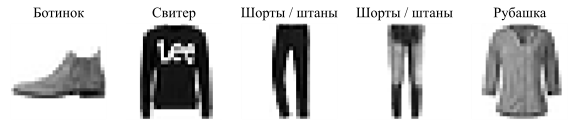

In [22]:
plt.figure(figsize=(2 * N, 5))
for i in range(N):
    plt.subplot(1, N, i+1)
    plt.imshow(test_images_show[i, :, :], cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.title(class_names[y_class[i]])
    plt.grid(False)
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [24]:
y_test_labels = np.argmax(y_test, axis=1)

In [25]:
test_confusion_matrix = confusion_matrix(y_test_labels, y_class)
print(test_confusion_matrix)

[[831   0  18  33   6   1 100   0  11   0]
 [  1 971   2  20   1   0   3   0   2   0]
 [ 23   2 824  12  91   1  43   0   4   0]
 [ 22   6  13 892  38   1  23   0   5   0]
 [  2   1  92  27 835   0  40   0   3   0]
 [  0   0   0   0   0 952   0  19   4  25]
 [116   2  86  33  90   0 661   0  12   0]
 [  0   0   0   0   0  17   0 915   1  67]
 [  6   0   6   2   6   3   6   3 968   0]
 [  1   0   0   0   0   6   0  14   0 979]]


In [26]:
print(class_names)

['Футболка / топ', 'Шорты / штаны', 'Свитер', 'Платье', 'Плащ', 'Сандали', 'Рубашка', 'Кроссовок', 'Сумка', 'Ботинок']


In [27]:
print(classification_report(y_test_labels, y_class))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.82      0.81      1000
           3       0.88      0.89      0.88      1000
           4       0.78      0.83      0.81      1000
           5       0.97      0.95      0.96      1000
           6       0.75      0.66      0.70      1000
           7       0.96      0.92      0.94      1000
           8       0.96      0.97      0.96      1000
           9       0.91      0.98      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Вывод:
* увеличение числа нейронов увеличивает качество модели. Однако, нет смысла сильно усложнять модель, т.к. результаты с 96 и 192 нейронами примерно одинаковы.
* При равном количестве настраиваемых параметров лучшая модель имела 3 слоя.
* Все оптимизаторы кроме SGD показали примерно одинаковую эффективность на данном датасете
* Модель показала низкую точность при распозновании свитеров, часто путая его с плащами и рубашками. При распознавании рубашек самый низкий recall (из-за их схожести со свитерами и футболками)